# Simulating Language, Lab 6, Compositionality from iterated learning

In this lab, we'll be building a replication of the simulation in [Kirby et al (2015)](https://www.sciencedirect.com/science/article/pii/S0010027715000815?via%3Dihub) which looks at how compositional structure can evolve if language is both transmitted to new learners each generation *and* used for communication. This is by the most complex model we've seen on the course - it combines a new language model, iterated learning and the Rational Speech Act model, so there is a lot to work through. 

The model below is a close-ish replication of the original paper, but with a noteable simplification, namely that learners assume that they are learning a single language (even if that language might actually have been generated by multiple speakers who might each have been speaking a different language). This simplification doesn't alter the results much and means that the code is simpler and runs faster. We also use the full RSA model here: in the 2015 paper we had a simple penalty for ambiguity, which was RSA-inspired but not the full deal; again, this doesn't seem to affect the results too much.

## Representing meanings, signals, and grammars

Unlike the language models we've been working with so far, in order to look at compositional structure we have to allow meanings and signals (words or sentences, depending on how you think of them - you might think of them as *forms* if you like a general, slightly ambiguous term) to consist of component parts: in a compositional language, the signal associated with a meaning depends in a predictable way on the components of that meaning, with each part of the signal conveying part of the meaning. 

In order to keep thing manageable we're using a very simple meaning space: each meaning consists of two features, each of which can take two possible values, which means there are 4 possible meanings our language has to encode. If it helps, you can think of the first meaning feature as corresponding to shape, and the second to colour. Then `0` might be *square*, `1` might be *circle*, `2` could be *red*, and `3` could be *blue*. In this way `02` represents the meaning *red square*. 

In the same way, our signal space consists of just four possible sentences (two-letter strings made up of *a*s and *b*s, i.e. `aa`, `ab`, `ba`, `bb`). Again, you can imagine that `a` and `b` correspond to different words and each signal consists of a two-word sentence, or you can imagine that they are morphemes and each signal consists of a multi-morphmeic word.

In [1]:
possible_meanings = ['02', '03', '12', '13']
possible_signals = ['aa', 'ab', 'ba', 'bb']

Now we have a representation of meanings and signals we can represent a language, which (like in Lab 5) is a list of pairings of meanings and their associated signals. We are using a slightly different representation this time: each language consists of exactly 4 entries - four meaning-signal pairings, one signal for each meaning. As in Lab 5, each item is a *pair*: the first item in the pair is the meaning, and the second is the signal. For example, here is a degenerate language, where every meaning is expressed using the same signal:

```python
a_degenerate_language = [('02','aa'),('03','aa'),('12','aa'),('13','aa')]
```

Notice that this is a bit different from how we were representing ambiguous signals in Lab 5, where meanings were represented as sets. 

And here is a compositional language, where there is a reliable correspondence between components of the meaning and components of the signal that expresses it:

```python
a_compositional_language = [('02', 'aa'), ('03', 'ab'), ('12', 'ba'), ('13', 'bb')]
```

Check that you understand how meanings, signals and languages are represented, and why `a_compositional_language` is compositional, then create another degenerate language and another compositional language.

Now that we have defined what a language looks like, we can lay out the hypothesis space - the space of all possible languages - and the priors for those languages. 

Before we go any further, how many possible languages do you think there will be, given that we have only 4 meanings to express and only 4 possible signals to express them?

The process of enumerating the possible languages and calculating their prior probability is actually slightly involved: the prior for each language depends on its coding length, so we have to write down a mini grammar for each language, calculate its coding length, and then work out the prior based on that. Rather than going through all this code here, we are simply going to provide you with lists of all the possible languages (`possible_languages`), and their (log) prior probabilities (`logpriors`), which we prepared in advance based on the method in the Kirby et al. (2015) paper: the nth item in the `logpriors` list is the prior for the nth langauge in `possible_languages`.

Additionally we provide a list of *types* for each language (in the same order as the `possible_languages` list). Type `0` means *degenerate*, type `1` means *holistic*, type `2` is *other* (e.g. languages that are partially degenerate), and type `3` is compositional.

In [2]:
possible_languages = [[('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'aa')], [('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'ab')], [('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'ba')], [('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'bb')], [('02', 'aa'), ('03', 'aa'), ('12', 'ab'), ('13', 'aa')], [('02', 'aa'), ('03', 'aa'), ('12', 'ab'), ('13', 'ab')], [('02', 'aa'), ('03', 'aa'), ('12', 'ab'), ('13', 'ba')], [('02', 'aa'), ('03', 'aa'), ('12', 'ab'), ('13', 'bb')], [('02', 'aa'), ('03', 'aa'), ('12', 'ba'), ('13', 'aa')], [('02', 'aa'), ('03', 'aa'), ('12', 'ba'), ('13', 'ab')], [('02', 'aa'), ('03', 'aa'), ('12', 'ba'), ('13', 'ba')], [('02', 'aa'), ('03', 'aa'), ('12', 'ba'), ('13', 'bb')], [('02', 'aa'), ('03', 'aa'), ('12', 'bb'), ('13', 'aa')], [('02', 'aa'), ('03', 'aa'), ('12', 'bb'), ('13', 'ab')], [('02', 'aa'), ('03', 'aa'), ('12', 'bb'), ('13', 'ba')], [('02', 'aa'), ('03', 'aa'), ('12', 'bb'), ('13', 'bb')], [('02', 'aa'), ('03', 'ab'), ('12', 'aa'), ('13', 'aa')], [('02', 'aa'), ('03', 'ab'), ('12', 'aa'), ('13', 'ab')], [('02', 'aa'), ('03', 'ab'), ('12', 'aa'), ('13', 'ba')], [('02', 'aa'), ('03', 'ab'), ('12', 'aa'), ('13', 'bb')], [('02', 'aa'), ('03', 'ab'), ('12', 'ab'), ('13', 'aa')], [('02', 'aa'), ('03', 'ab'), ('12', 'ab'), ('13', 'ab')], [('02', 'aa'), ('03', 'ab'), ('12', 'ab'), ('13', 'ba')], [('02', 'aa'), ('03', 'ab'), ('12', 'ab'), ('13', 'bb')], [('02', 'aa'), ('03', 'ab'), ('12', 'ba'), ('13', 'aa')], [('02', 'aa'), ('03', 'ab'), ('12', 'ba'), ('13', 'ab')], [('02', 'aa'), ('03', 'ab'), ('12', 'ba'), ('13', 'ba')], [('02', 'aa'), ('03', 'ab'), ('12', 'ba'), ('13', 'bb')], [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'aa')], [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ab')], [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')], [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'bb')], [('02', 'aa'), ('03', 'ba'), ('12', 'aa'), ('13', 'aa')], [('02', 'aa'), ('03', 'ba'), ('12', 'aa'), ('13', 'ab')], [('02', 'aa'), ('03', 'ba'), ('12', 'aa'), ('13', 'ba')], [('02', 'aa'), ('03', 'ba'), ('12', 'aa'), ('13', 'bb')], [('02', 'aa'), ('03', 'ba'), ('12', 'ab'), ('13', 'aa')], [('02', 'aa'), ('03', 'ba'), ('12', 'ab'), ('13', 'ab')], [('02', 'aa'), ('03', 'ba'), ('12', 'ab'), ('13', 'ba')], [('02', 'aa'), ('03', 'ba'), ('12', 'ab'), ('13', 'bb')], [('02', 'aa'), ('03', 'ba'), ('12', 'ba'), ('13', 'aa')], [('02', 'aa'), ('03', 'ba'), ('12', 'ba'), ('13', 'ab')], [('02', 'aa'), ('03', 'ba'), ('12', 'ba'), ('13', 'ba')], [('02', 'aa'), ('03', 'ba'), ('12', 'ba'), ('13', 'bb')], [('02', 'aa'), ('03', 'ba'), ('12', 'bb'), ('13', 'aa')], [('02', 'aa'), ('03', 'ba'), ('12', 'bb'), ('13', 'ab')], [('02', 'aa'), ('03', 'ba'), ('12', 'bb'), ('13', 'ba')], [('02', 'aa'), ('03', 'ba'), ('12', 'bb'), ('13', 'bb')], [('02', 'aa'), ('03', 'bb'), ('12', 'aa'), ('13', 'aa')], [('02', 'aa'), ('03', 'bb'), ('12', 'aa'), ('13', 'ab')], [('02', 'aa'), ('03', 'bb'), ('12', 'aa'), ('13', 'ba')], [('02', 'aa'), ('03', 'bb'), ('12', 'aa'), ('13', 'bb')], [('02', 'aa'), ('03', 'bb'), ('12', 'ab'), ('13', 'aa')], [('02', 'aa'), ('03', 'bb'), ('12', 'ab'), ('13', 'ab')], [('02', 'aa'), ('03', 'bb'), ('12', 'ab'), ('13', 'ba')], [('02', 'aa'), ('03', 'bb'), ('12', 'ab'), ('13', 'bb')], [('02', 'aa'), ('03', 'bb'), ('12', 'ba'), ('13', 'aa')], [('02', 'aa'), ('03', 'bb'), ('12', 'ba'), ('13', 'ab')], [('02', 'aa'), ('03', 'bb'), ('12', 'ba'), ('13', 'ba')], [('02', 'aa'), ('03', 'bb'), ('12', 'ba'), ('13', 'bb')], [('02', 'aa'), ('03', 'bb'), ('12', 'bb'), ('13', 'aa')], [('02', 'aa'), ('03', 'bb'), ('12', 'bb'), ('13', 'ab')], [('02', 'aa'), ('03', 'bb'), ('12', 'bb'), ('13', 'ba')], [('02', 'aa'), ('03', 'bb'), ('12', 'bb'), ('13', 'bb')], [('02', 'ab'), ('03', 'aa'), ('12', 'aa'), ('13', 'aa')], [('02', 'ab'), ('03', 'aa'), ('12', 'aa'), ('13', 'ab')], [('02', 'ab'), ('03', 'aa'), ('12', 'aa'), ('13', 'ba')], [('02', 'ab'), ('03', 'aa'), ('12', 'aa'), ('13', 'bb')], [('02', 'ab'), ('03', 'aa'), ('12', 'ab'), ('13', 'aa')], [('02', 'ab'), ('03', 'aa'), ('12', 'ab'), ('13', 'ab')], [('02', 'ab'), ('03', 'aa'), ('12', 'ab'), ('13', 'ba')], [('02', 'ab'), ('03', 'aa'), ('12', 'ab'), ('13', 'bb')], [('02', 'ab'), ('03', 'aa'), ('12', 'ba'), ('13', 'aa')], [('02', 'ab'), ('03', 'aa'), ('12', 'ba'), ('13', 'ab')], [('02', 'ab'), ('03', 'aa'), ('12', 'ba'), ('13', 'ba')], [('02', 'ab'), ('03', 'aa'), ('12', 'ba'), ('13', 'bb')], [('02', 'ab'), ('03', 'aa'), ('12', 'bb'), ('13', 'aa')], [('02', 'ab'), ('03', 'aa'), ('12', 'bb'), ('13', 'ab')], [('02', 'ab'), ('03', 'aa'), ('12', 'bb'), ('13', 'ba')], [('02', 'ab'), ('03', 'aa'), ('12', 'bb'), ('13', 'bb')], [('02', 'ab'), ('03', 'ab'), ('12', 'aa'), ('13', 'aa')], [('02', 'ab'), ('03', 'ab'), ('12', 'aa'), ('13', 'ab')], [('02', 'ab'), ('03', 'ab'), ('12', 'aa'), ('13', 'ba')], [('02', 'ab'), ('03', 'ab'), ('12', 'aa'), ('13', 'bb')], [('02', 'ab'), ('03', 'ab'), ('12', 'ab'), ('13', 'aa')], [('02', 'ab'), ('03', 'ab'), ('12', 'ab'), ('13', 'ab')], [('02', 'ab'), ('03', 'ab'), ('12', 'ab'), ('13', 'ba')], [('02', 'ab'), ('03', 'ab'), ('12', 'ab'), ('13', 'bb')], [('02', 'ab'), ('03', 'ab'), ('12', 'ba'), ('13', 'aa')], [('02', 'ab'), ('03', 'ab'), ('12', 'ba'), ('13', 'ab')], [('02', 'ab'), ('03', 'ab'), ('12', 'ba'), ('13', 'ba')], [('02', 'ab'), ('03', 'ab'), ('12', 'ba'), ('13', 'bb')], [('02', 'ab'), ('03', 'ab'), ('12', 'bb'), ('13', 'aa')], [('02', 'ab'), ('03', 'ab'), ('12', 'bb'), ('13', 'ab')], [('02', 'ab'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')], [('02', 'ab'), ('03', 'ab'), ('12', 'bb'), ('13', 'bb')], [('02', 'ab'), ('03', 'ba'), ('12', 'aa'), ('13', 'aa')], [('02', 'ab'), ('03', 'ba'), ('12', 'aa'), ('13', 'ab')], [('02', 'ab'), ('03', 'ba'), ('12', 'aa'), ('13', 'ba')], [('02', 'ab'), ('03', 'ba'), ('12', 'aa'), ('13', 'bb')], [('02', 'ab'), ('03', 'ba'), ('12', 'ab'), ('13', 'aa')], [('02', 'ab'), ('03', 'ba'), ('12', 'ab'), ('13', 'ab')], [('02', 'ab'), ('03', 'ba'), ('12', 'ab'), ('13', 'ba')], [('02', 'ab'), ('03', 'ba'), ('12', 'ab'), ('13', 'bb')], [('02', 'ab'), ('03', 'ba'), ('12', 'ba'), ('13', 'aa')], [('02', 'ab'), ('03', 'ba'), ('12', 'ba'), ('13', 'ab')], [('02', 'ab'), ('03', 'ba'), ('12', 'ba'), ('13', 'ba')], [('02', 'ab'), ('03', 'ba'), ('12', 'ba'), ('13', 'bb')], [('02', 'ab'), ('03', 'ba'), ('12', 'bb'), ('13', 'aa')], [('02', 'ab'), ('03', 'ba'), ('12', 'bb'), ('13', 'ab')], [('02', 'ab'), ('03', 'ba'), ('12', 'bb'), ('13', 'ba')], [('02', 'ab'), ('03', 'ba'), ('12', 'bb'), ('13', 'bb')], [('02', 'ab'), ('03', 'bb'), ('12', 'aa'), ('13', 'aa')], [('02', 'ab'), ('03', 'bb'), ('12', 'aa'), ('13', 'ab')], [('02', 'ab'), ('03', 'bb'), ('12', 'aa'), ('13', 'ba')], [('02', 'ab'), ('03', 'bb'), ('12', 'aa'), ('13', 'bb')], [('02', 'ab'), ('03', 'bb'), ('12', 'ab'), ('13', 'aa')], [('02', 'ab'), ('03', 'bb'), ('12', 'ab'), ('13', 'ab')], [('02', 'ab'), ('03', 'bb'), ('12', 'ab'), ('13', 'ba')], [('02', 'ab'), ('03', 'bb'), ('12', 'ab'), ('13', 'bb')], [('02', 'ab'), ('03', 'bb'), ('12', 'ba'), ('13', 'aa')], [('02', 'ab'), ('03', 'bb'), ('12', 'ba'), ('13', 'ab')], [('02', 'ab'), ('03', 'bb'), ('12', 'ba'), ('13', 'ba')], [('02', 'ab'), ('03', 'bb'), ('12', 'ba'), ('13', 'bb')], [('02', 'ab'), ('03', 'bb'), ('12', 'bb'), ('13', 'aa')], [('02', 'ab'), ('03', 'bb'), ('12', 'bb'), ('13', 'ab')], [('02', 'ab'), ('03', 'bb'), ('12', 'bb'), ('13', 'ba')], [('02', 'ab'), ('03', 'bb'), ('12', 'bb'), ('13', 'bb')], [('02', 'ba'), ('03', 'aa'), ('12', 'aa'), ('13', 'aa')], [('02', 'ba'), ('03', 'aa'), ('12', 'aa'), ('13', 'ab')], [('02', 'ba'), ('03', 'aa'), ('12', 'aa'), ('13', 'ba')], [('02', 'ba'), ('03', 'aa'), ('12', 'aa'), ('13', 'bb')], [('02', 'ba'), ('03', 'aa'), ('12', 'ab'), ('13', 'aa')], [('02', 'ba'), ('03', 'aa'), ('12', 'ab'), ('13', 'ab')], [('02', 'ba'), ('03', 'aa'), ('12', 'ab'), ('13', 'ba')], [('02', 'ba'), ('03', 'aa'), ('12', 'ab'), ('13', 'bb')], [('02', 'ba'), ('03', 'aa'), ('12', 'ba'), ('13', 'aa')], [('02', 'ba'), ('03', 'aa'), ('12', 'ba'), ('13', 'ab')], [('02', 'ba'), ('03', 'aa'), ('12', 'ba'), ('13', 'ba')], [('02', 'ba'), ('03', 'aa'), ('12', 'ba'), ('13', 'bb')], [('02', 'ba'), ('03', 'aa'), ('12', 'bb'), ('13', 'aa')], [('02', 'ba'), ('03', 'aa'), ('12', 'bb'), ('13', 'ab')], [('02', 'ba'), ('03', 'aa'), ('12', 'bb'), ('13', 'ba')], [('02', 'ba'), ('03', 'aa'), ('12', 'bb'), ('13', 'bb')], [('02', 'ba'), ('03', 'ab'), ('12', 'aa'), ('13', 'aa')], [('02', 'ba'), ('03', 'ab'), ('12', 'aa'), ('13', 'ab')], [('02', 'ba'), ('03', 'ab'), ('12', 'aa'), ('13', 'ba')], [('02', 'ba'), ('03', 'ab'), ('12', 'aa'), ('13', 'bb')], [('02', 'ba'), ('03', 'ab'), ('12', 'ab'), ('13', 'aa')], [('02', 'ba'), ('03', 'ab'), ('12', 'ab'), ('13', 'ab')], [('02', 'ba'), ('03', 'ab'), ('12', 'ab'), ('13', 'ba')], [('02', 'ba'), ('03', 'ab'), ('12', 'ab'), ('13', 'bb')], [('02', 'ba'), ('03', 'ab'), ('12', 'ba'), ('13', 'aa')], [('02', 'ba'), ('03', 'ab'), ('12', 'ba'), ('13', 'ab')], [('02', 'ba'), ('03', 'ab'), ('12', 'ba'), ('13', 'ba')], [('02', 'ba'), ('03', 'ab'), ('12', 'ba'), ('13', 'bb')], [('02', 'ba'), ('03', 'ab'), ('12', 'bb'), ('13', 'aa')], [('02', 'ba'), ('03', 'ab'), ('12', 'bb'), ('13', 'ab')], [('02', 'ba'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')], [('02', 'ba'), ('03', 'ab'), ('12', 'bb'), ('13', 'bb')], [('02', 'ba'), ('03', 'ba'), ('12', 'aa'), ('13', 'aa')], [('02', 'ba'), ('03', 'ba'), ('12', 'aa'), ('13', 'ab')], [('02', 'ba'), ('03', 'ba'), ('12', 'aa'), ('13', 'ba')], [('02', 'ba'), ('03', 'ba'), ('12', 'aa'), ('13', 'bb')], [('02', 'ba'), ('03', 'ba'), ('12', 'ab'), ('13', 'aa')], [('02', 'ba'), ('03', 'ba'), ('12', 'ab'), ('13', 'ab')], [('02', 'ba'), ('03', 'ba'), ('12', 'ab'), ('13', 'ba')], [('02', 'ba'), ('03', 'ba'), ('12', 'ab'), ('13', 'bb')], [('02', 'ba'), ('03', 'ba'), ('12', 'ba'), ('13', 'aa')], [('02', 'ba'), ('03', 'ba'), ('12', 'ba'), ('13', 'ab')], [('02', 'ba'), ('03', 'ba'), ('12', 'ba'), ('13', 'ba')], [('02', 'ba'), ('03', 'ba'), ('12', 'ba'), ('13', 'bb')], [('02', 'ba'), ('03', 'ba'), ('12', 'bb'), ('13', 'aa')], [('02', 'ba'), ('03', 'ba'), ('12', 'bb'), ('13', 'ab')], [('02', 'ba'), ('03', 'ba'), ('12', 'bb'), ('13', 'ba')], [('02', 'ba'), ('03', 'ba'), ('12', 'bb'), ('13', 'bb')], [('02', 'ba'), ('03', 'bb'), ('12', 'aa'), ('13', 'aa')], [('02', 'ba'), ('03', 'bb'), ('12', 'aa'), ('13', 'ab')], [('02', 'ba'), ('03', 'bb'), ('12', 'aa'), ('13', 'ba')], [('02', 'ba'), ('03', 'bb'), ('12', 'aa'), ('13', 'bb')], [('02', 'ba'), ('03', 'bb'), ('12', 'ab'), ('13', 'aa')], [('02', 'ba'), ('03', 'bb'), ('12', 'ab'), ('13', 'ab')], [('02', 'ba'), ('03', 'bb'), ('12', 'ab'), ('13', 'ba')], [('02', 'ba'), ('03', 'bb'), ('12', 'ab'), ('13', 'bb')], [('02', 'ba'), ('03', 'bb'), ('12', 'ba'), ('13', 'aa')], [('02', 'ba'), ('03', 'bb'), ('12', 'ba'), ('13', 'ab')], [('02', 'ba'), ('03', 'bb'), ('12', 'ba'), ('13', 'ba')], [('02', 'ba'), ('03', 'bb'), ('12', 'ba'), ('13', 'bb')], [('02', 'ba'), ('03', 'bb'), ('12', 'bb'), ('13', 'aa')], [('02', 'ba'), ('03', 'bb'), ('12', 'bb'), ('13', 'ab')], [('02', 'ba'), ('03', 'bb'), ('12', 'bb'), ('13', 'ba')], [('02', 'ba'), ('03', 'bb'), ('12', 'bb'), ('13', 'bb')], [('02', 'bb'), ('03', 'aa'), ('12', 'aa'), ('13', 'aa')], [('02', 'bb'), ('03', 'aa'), ('12', 'aa'), ('13', 'ab')], [('02', 'bb'), ('03', 'aa'), ('12', 'aa'), ('13', 'ba')], [('02', 'bb'), ('03', 'aa'), ('12', 'aa'), ('13', 'bb')], [('02', 'bb'), ('03', 'aa'), ('12', 'ab'), ('13', 'aa')], [('02', 'bb'), ('03', 'aa'), ('12', 'ab'), ('13', 'ab')], [('02', 'bb'), ('03', 'aa'), ('12', 'ab'), ('13', 'ba')], [('02', 'bb'), ('03', 'aa'), ('12', 'ab'), ('13', 'bb')], [('02', 'bb'), ('03', 'aa'), ('12', 'ba'), ('13', 'aa')], [('02', 'bb'), ('03', 'aa'), ('12', 'ba'), ('13', 'ab')], [('02', 'bb'), ('03', 'aa'), ('12', 'ba'), ('13', 'ba')], [('02', 'bb'), ('03', 'aa'), ('12', 'ba'), ('13', 'bb')], [('02', 'bb'), ('03', 'aa'), ('12', 'bb'), ('13', 'aa')], [('02', 'bb'), ('03', 'aa'), ('12', 'bb'), ('13', 'ab')], [('02', 'bb'), ('03', 'aa'), ('12', 'bb'), ('13', 'ba')], [('02', 'bb'), ('03', 'aa'), ('12', 'bb'), ('13', 'bb')], [('02', 'bb'), ('03', 'ab'), ('12', 'aa'), ('13', 'aa')], [('02', 'bb'), ('03', 'ab'), ('12', 'aa'), ('13', 'ab')], [('02', 'bb'), ('03', 'ab'), ('12', 'aa'), ('13', 'ba')], [('02', 'bb'), ('03', 'ab'), ('12', 'aa'), ('13', 'bb')], [('02', 'bb'), ('03', 'ab'), ('12', 'ab'), ('13', 'aa')], [('02', 'bb'), ('03', 'ab'), ('12', 'ab'), ('13', 'ab')], [('02', 'bb'), ('03', 'ab'), ('12', 'ab'), ('13', 'ba')], [('02', 'bb'), ('03', 'ab'), ('12', 'ab'), ('13', 'bb')], [('02', 'bb'), ('03', 'ab'), ('12', 'ba'), ('13', 'aa')], [('02', 'bb'), ('03', 'ab'), ('12', 'ba'), ('13', 'ab')], [('02', 'bb'), ('03', 'ab'), ('12', 'ba'), ('13', 'ba')], [('02', 'bb'), ('03', 'ab'), ('12', 'ba'), ('13', 'bb')], [('02', 'bb'), ('03', 'ab'), ('12', 'bb'), ('13', 'aa')], [('02', 'bb'), ('03', 'ab'), ('12', 'bb'), ('13', 'ab')], [('02', 'bb'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')], [('02', 'bb'), ('03', 'ab'), ('12', 'bb'), ('13', 'bb')], [('02', 'bb'), ('03', 'ba'), ('12', 'aa'), ('13', 'aa')], [('02', 'bb'), ('03', 'ba'), ('12', 'aa'), ('13', 'ab')], [('02', 'bb'), ('03', 'ba'), ('12', 'aa'), ('13', 'ba')], [('02', 'bb'), ('03', 'ba'), ('12', 'aa'), ('13', 'bb')], [('02', 'bb'), ('03', 'ba'), ('12', 'ab'), ('13', 'aa')], [('02', 'bb'), ('03', 'ba'), ('12', 'ab'), ('13', 'ab')], [('02', 'bb'), ('03', 'ba'), ('12', 'ab'), ('13', 'ba')], [('02', 'bb'), ('03', 'ba'), ('12', 'ab'), ('13', 'bb')], [('02', 'bb'), ('03', 'ba'), ('12', 'ba'), ('13', 'aa')], [('02', 'bb'), ('03', 'ba'), ('12', 'ba'), ('13', 'ab')], [('02', 'bb'), ('03', 'ba'), ('12', 'ba'), ('13', 'ba')], [('02', 'bb'), ('03', 'ba'), ('12', 'ba'), ('13', 'bb')], [('02', 'bb'), ('03', 'ba'), ('12', 'bb'), ('13', 'aa')], [('02', 'bb'), ('03', 'ba'), ('12', 'bb'), ('13', 'ab')], [('02', 'bb'), ('03', 'ba'), ('12', 'bb'), ('13', 'ba')], [('02', 'bb'), ('03', 'ba'), ('12', 'bb'), ('13', 'bb')], [('02', 'bb'), ('03', 'bb'), ('12', 'aa'), ('13', 'aa')], [('02', 'bb'), ('03', 'bb'), ('12', 'aa'), ('13', 'ab')], [('02', 'bb'), ('03', 'bb'), ('12', 'aa'), ('13', 'ba')], [('02', 'bb'), ('03', 'bb'), ('12', 'aa'), ('13', 'bb')], [('02', 'bb'), ('03', 'bb'), ('12', 'ab'), ('13', 'aa')], [('02', 'bb'), ('03', 'bb'), ('12', 'ab'), ('13', 'ab')], [('02', 'bb'), ('03', 'bb'), ('12', 'ab'), ('13', 'ba')], [('02', 'bb'), ('03', 'bb'), ('12', 'ab'), ('13', 'bb')], [('02', 'bb'), ('03', 'bb'), ('12', 'ba'), ('13', 'aa')], [('02', 'bb'), ('03', 'bb'), ('12', 'ba'), ('13', 'ab')], [('02', 'bb'), ('03', 'bb'), ('12', 'ba'), ('13', 'ba')], [('02', 'bb'), ('03', 'bb'), ('12', 'ba'), ('13', 'bb')], [('02', 'bb'), ('03', 'bb'), ('12', 'bb'), ('13', 'aa')], [('02', 'bb'), ('03', 'bb'), ('12', 'bb'), ('13', 'ab')], [('02', 'bb'), ('03', 'bb'), ('12', 'bb'), ('13', 'ba')], [('02', 'bb'), ('03', 'bb'), ('12', 'bb'), ('13', 'bb')]]
logpriors = [-0.9178860550328204, -10.749415928290118, -10.749415928290118, -11.272664072079987, -10.749415928290118, -10.749415928290118, -16.95425710594061, -17.294055179550075, -10.749415928290118, -16.95425710594061, -10.749415928290118, -17.294055179550075, -11.272664072079987, -17.294055179550075, -17.294055179550075, -11.272664072079987, -10.749415928290118, -10.749415928290118, -16.95425710594061, -17.294055179550075, -10.749415928290118, -10.749415928290118, -16.95425710594061, -17.294055179550075, -16.95425710594061, -16.95425710594061, -16.95425710594061, -12.460704095246543, -17.294055179550075, -17.294055179550075, -20.83821243446749, -17.294055179550075, -10.749415928290118, -16.95425710594061, -10.749415928290118, -17.294055179550075, -16.95425710594061, -16.95425710594061, -16.95425710594061, -12.460704095246543, -10.749415928290118, -16.95425710594061, -10.749415928290118, -17.294055179550075, -17.294055179550075, -20.83821243446749, -17.294055179550075, -17.294055179550075, -11.272664072079987, -17.294055179550075, -17.294055179550075, -11.272664072079987, -17.294055179550075, -17.294055179550075, -20.83821243446749, -17.294055179550075, -17.294055179550075, -20.83821243446749, -17.294055179550075, -17.294055179550075, -11.272664072079987, -17.294055179550075, -17.294055179550075, -11.272664072079987, -10.749415928290118, -10.749415928290118, -16.95425710594061, -17.294055179550075, -10.749415928290118, -10.749415928290118, -16.95425710594061, -17.294055179550075, -16.95425710594061, -16.95425710594061, -16.95425710594061, -20.83821243446749, -17.294055179550075, -17.294055179550075, -12.460704095246543, -17.294055179550075, -10.749415928290118, -10.749415928290118, -16.95425710594061, -17.294055179550075, -10.749415928290118, -2.304180416152711, -11.272664072079987, -10.749415928290118, -16.95425710594061, -11.272664072079987, -11.272664072079987, -16.95425710594061, -17.294055179550075, -10.749415928290118, -16.95425710594061, -10.749415928290118, -16.95425710594061, -16.95425710594061, -16.95425710594061, -20.83821243446749, -16.95425710594061, -11.272664072079987, -11.272664072079987, -16.95425710594061, -16.95425710594061, -11.272664072079987, -11.272664072079987, -16.95425710594061, -20.83821243446749, -16.95425710594061, -16.95425710594061, -16.95425710594061, -17.294055179550075, -17.294055179550075, -12.460704095246543, -17.294055179550075, -17.294055179550075, -10.749415928290118, -16.95425710594061, -10.749415928290118, -20.83821243446749, -16.95425710594061, -16.95425710594061, -16.95425710594061, -17.294055179550075, -10.749415928290118, -16.95425710594061, -10.749415928290118, -10.749415928290118, -16.95425710594061, -10.749415928290118, -17.294055179550075, -16.95425710594061, -16.95425710594061, -16.95425710594061, -20.83821243446749, -10.749415928290118, -16.95425710594061, -10.749415928290118, -17.294055179550075, -17.294055179550075, -12.460704095246543, -17.294055179550075, -17.294055179550075, -16.95425710594061, -16.95425710594061, -16.95425710594061, -20.83821243446749, -16.95425710594061, -11.272664072079987, -11.272664072079987, -16.95425710594061, -16.95425710594061, -11.272664072079987, -11.272664072079987, -16.95425710594061, -20.83821243446749, -16.95425710594061, -16.95425710594061, -16.95425710594061, -10.749415928290118, -16.95425710594061, -10.749415928290118, -17.294055179550075, -16.95425710594061, -11.272664072079987, -11.272664072079987, -16.95425710594061, -10.749415928290118, -11.272664072079987, -2.304180416152711, -10.749415928290118, -17.294055179550075, -16.95425710594061, -10.749415928290118, -10.749415928290118, -17.294055179550075, -12.460704095246543, -17.294055179550075, -17.294055179550075, -20.83821243446749, -16.95425710594061, -16.95425710594061, -16.95425710594061, -17.294055179550075, -16.95425710594061, -10.749415928290118, -10.749415928290118, -17.294055179550075, -16.95425710594061, -10.749415928290118, -10.749415928290118, -11.272664072079987, -17.294055179550075, -17.294055179550075, -11.272664072079987, -17.294055179550075, -17.294055179550075, -20.83821243446749, -17.294055179550075, -17.294055179550075, -20.83821243446749, -17.294055179550075, -17.294055179550075, -11.272664072079987, -17.294055179550075, -17.294055179550075, -11.272664072079987, -17.294055179550075, -17.294055179550075, -20.83821243446749, -17.294055179550075, -17.294055179550075, -10.749415928290118, -16.95425710594061, -10.749415928290118, -12.460704095246543, -16.95425710594061, -16.95425710594061, -16.95425710594061, -17.294055179550075, -10.749415928290118, -16.95425710594061, -10.749415928290118, -17.294055179550075, -20.83821243446749, -17.294055179550075, -17.294055179550075, -12.460704095246543, -16.95425710594061, -16.95425710594061, -16.95425710594061, -17.294055179550075, -16.95425710594061, -10.749415928290118, -10.749415928290118, -17.294055179550075, -16.95425710594061, -10.749415928290118, -10.749415928290118, -11.272664072079987, -17.294055179550075, -17.294055179550075, -11.272664072079987, -17.294055179550075, -10.749415928290118, -16.95425710594061, -10.749415928290118, -17.294055179550075, -16.95425710594061, -10.749415928290118, -10.749415928290118, -11.272664072079987, -10.749415928290118, -10.749415928290118, -0.9178860550328204]
language_types = [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0]

Measure the length of `possible_languages` to check whether you correctly figured out how many possible languages there should be. Using the `language_types` list, can you find the first holistic language in the list? Does it make sense that this language is classed as holistic? How does its prior probability compare to the first degenerate language in the list?

If you want to see all the languages laid out along with their type and prior, you can do something like this:
```python
for i in range(len(possible_languages)):
    print(possible_languages[i],language_types[i],logpriors[i])
```

In [3]:
for i in range(len(possible_languages)):
    print(possible_languages[i],language_types[i],logpriors[i])

[('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'aa')] 0 -0.9178860550328204
[('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'ab')] 2 -10.749415928290118
[('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'ba')] 2 -10.749415928290118
[('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'bb')] 2 -11.272664072079987
[('02', 'aa'), ('03', 'aa'), ('12', 'ab'), ('13', 'aa')] 2 -10.749415928290118
[('02', 'aa'), ('03', 'aa'), ('12', 'ab'), ('13', 'ab')] 2 -10.749415928290118
[('02', 'aa'), ('03', 'aa'), ('12', 'ab'), ('13', 'ba')] 2 -16.95425710594061
[('02', 'aa'), ('03', 'aa'), ('12', 'ab'), ('13', 'bb')] 2 -17.294055179550075
[('02', 'aa'), ('03', 'aa'), ('12', 'ba'), ('13', 'aa')] 2 -10.749415928290118
[('02', 'aa'), ('03', 'aa'), ('12', 'ba'), ('13', 'ab')] 2 -16.95425710594061
[('02', 'aa'), ('03', 'aa'), ('12', 'ba'), ('13', 'ba')] 2 -10.749415928290118
[('02', 'aa'), ('03', 'aa'), ('12', 'ba'), ('13', 'bb')] 2 -17.294055179550075
[('02', 'aa'), ('03', 'aa'), ('12', 'bb'), ('13', 'aa'

## The rest of the code

Now we have our representation of languages we can get on with the rest of the code. First we'll import our various libraries and define the usual functions we need for working with log probabilities. We also import the `functools` library which is going to help us speed up our code so it runs in a reasonable time! I'll explain that bit when we get to it.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

import random
from math import log, log1p, exp
from scipy.special import logsumexp

import functools #provides a handy function for speeding up our code

def log_subtract(x,y):
    return x + log1p(-exp(y - x))

def normalize_logprobs(logprobs):
    logtotal = logsumexp(logprobs) #calculates the summed log probabilities
    normedlogs = []
    for logp in logprobs:
        normedlogs.append(logp - logtotal) #normalise - subtracting in the log domain equivalent to divising in the normal domain
    return normedlogs

def log_roulette_wheel(normedlogs):
    r=log(random.random()) #generate a random number in [0,1), then convert to log
    accumulator = normedlogs[0]
    for i in range(len(normedlogs)):
        if r < accumulator:
            return i
        accumulator = logsumexp([accumulator, normedlogs[i + 1]])

### More simulation parameters

We defined a couple of parameters above: `possible_meanings` and `possible_signals`. Here we define a couple more. The parameter `error_probability` is the probability a speaker produces the "wrong" signal for a meaning. We used this in Lab 5 as a way of ensuring that we never end up dealing with the logs of 0 probabilities, which cause the code to break - it does that job here too, but in our iterated learning simulation this parameter also provides a way in which languages can change and evolve over time. Learners take this value into account when calculating the likelihood of the data they see, which means that they understand that sometimes a speaker can generate "wrong" data; this means that learners therefore won't assign a dataset with the occasional "error" in it zero probability, which provides the language a little wiggle room, allowing learners to reinterpret the data they encounter.

The `communication` parameter says whether or not the speaker will try to be pragmatic in their communication, i.e. selecting signals which are more likely to be correctly interpreted by the listener. The `turnover` parameter states whether new individuals enter the population or not.

In [5]:
error_probability = 0.06 #note that this is a probability, not a log probability
communication = False
turnover = True

### The prior and the likelihood

The `logprior` function just takes a language and looks up its (log) prior probability from the list we defined above. We are using the `index` function here as a handy shortcut: `a_list.index(value)` returns the index of the first occurence of `value` in `a_list`, so we can use it to look up the position of a particular language (or meaning or signal) in our pre-defined lists. If you want to see how `index` works, try something like: 
```python
my_list = ['a','b','c','b']
print(my_list.index('c'))
print(my_list.index('b'))
```

In [6]:
def logprior(language):
    language_index = possible_languages.index(language)
    return logpriors[language_index]

For the likelihood (our model of how someone with a particular language in their head behaves when communicating) we are going to use the RSA model we developed in Lab 5: we'll define a literal speaker, `s0`, who just uses the language in an unreflective, by-the-book way, and a pragmatic speaker, `s1`, who reasons about the likely behaviour of a literal listener `l0` when selecting signals to convey meanings; the pragmatic speaker selects signals based on their probability of being correctly understood by the literal listener. 

The implementation of `s0`, `l0` and `s1` are very similar to the equivalent functions in Lab 5. But, unlike in Lab 5, we are going to be calling these functions many thousands of times in the course of a simulation: every time one of our simulated learners produces data or learns from data produced by someone else, we have to calculate the likelihood of the data under each of the languages in our hypothesis space. This means we end up doing the same calculations over and over again, which can make our simulations quite slow to run. 

To get around this we are going to use a little trick called *memoization* (the name intentionally sounds a lot like "memorization"): we instruct the computer to remember the results of previous calculations, then if it has to re-do a calculation it's already done, it can just retrieve the previously-calculated result. This is a handy trick in any programming language, and it's extremely easy to do in python, using the `lru_cache` function from the `functools` library. **It is not important that you understand how memoization works**, as long as you get the idea that we are just speeding up the code by storing previously-calculated results for the `s0`, `l0` and `s1` functions: all you need to know is that our `s0`, `l0` and `s1` functions call memoized versions of themselves, called `s0_memoized`, `l0_memoized` and `s1_memoized`. (If you are a python programmer you'll notice that all the wrapper functions do is temporarily represent the language as a tuple rather than a list, because memoization involves a hash table and lists can't be used as hashes in python). If you'd like to read more about memoization, I found this blogpost quite helpful: https://dbader.org/blog/python-memoization. But again, there's no need to dwell on this unless you are interested in how the code works under the hood.

There's only one downside to memoization in our case, which is if we change any of our fixed simulation parameters which are involved in calculating likelihoods (specifically: `possible_meanings`, `possible_signals`, `error_probability`), we have to wipe all our stored results, otherwise the code will behave strangely (it will look up previously-stored results calculated using the old values of these patrameters). You can do this using the `wipe_stored_results()` function I have provided below.

In [7]:
def s0(target_meaning,language):
    return s0_memoized(target_meaning,tuple(language))

@functools.lru_cache(maxsize=None) #this is all you need for memoization in python, very handy
def s0_memoized(target_meaning,tuple_language):
    language = list(tuple_language)
    signal_probs = []
    for candidate_signal in possible_signals: #consider each possible signal
        if (target_meaning, candidate_signal) in language:
            signal_probs.append(log(1 - error_probability))
        else: #error probability mass spread over all other possible signals
            signal_probs.append(log(error_probability/(len(possible_signals)-1)))               
    return normalize_logprobs(signal_probs) #normalise these so they are true log probabilities

In [8]:
def l0(received_signal,language):
    return l0_memoized(received_signal,tuple(language))

@functools.lru_cache(maxsize=None)
def l0_memoized(received_signal,tuple_language):
    language = list(tuple_language)
    meaning_probs = []
    for candidate_meaning in possible_meanings: #consider each possible meaning
        if (candidate_meaning, received_signal) in language:
            meaning_probs.append(log(1 - error_probability))
        else: #error probability mass spread over all other possible meanings
            meaning_probs.append(log(error_probability/(len(possible_meanings)-1)))              
    return normalize_logprobs(meaning_probs) #normalise these so they are true log probabilities

In [9]:
def s1(target_meaning,language):
    return s1_memoized(target_meaning,tuple(language))

@functools.lru_cache(maxsize=None)
def s1_memoized(target_meaning,tuple_language):
    language = list(tuple_language)
    signal_probs = []
    target_meaning_index = possible_meanings.index(target_meaning)
    for candidate_signal in possible_signals: #consider each candidate signal
        #how likely is the literal listener to choose target_meaning if they hear this signal?
        l0_prob_of_target_meaning = l0(candidate_signal,language)[target_meaning_index]  
        signal_probs.append(l0_prob_of_target_meaning)#note that down
    return normalize_logprobs(signal_probs) #and normalise at the end

In [10]:
#used to wipe stored results from memoization tables
def wipe_stored_results():
    s0_memoized.cache_clear()
    l0_memoized.cache_clear()
    s1_memoized.cache_clear()

#for the geeks: used to inspect the memoization tables
def inspect_stored_results():
    print(s0_memoized.cache_info())
    print(l0_memoized.cache_info())
    print(s1_memoized.cache_info())

If you want to have a check how `s0` or `s1` behaves, you can do something like this to see nicely-formatted production probabilities:

```python
m='02'
language_number = 100
print('Literal speaker of language number',language_number,'target meaning',m)
print('Language',language_number,':',possible_languages[language_number])
signal_probabilities = s0(m,possible_languages[language_number])
for i in range(len(possible_signals)):
    print(possible_signals[i],exp(signal_probabilities[i]))
```

In [11]:
m='02'
language_number = 100
print('Literal speaker of language number',language_number,'target meaning',m)
print('Language',language_number,':',possible_languages[language_number])
signal_probabilities = s0(m,possible_languages[language_number])
for i in range(len(possible_signals)):
    print(possible_signals[i],exp(signal_probabilities[i]))

Literal speaker of language number 100 target meaning 02
Language 100 : [('02', 'ab'), ('03', 'ba'), ('12', 'ab'), ('13', 'aa')]
aa 0.02000000000000001
ab 0.9400000000000002
ba 0.02000000000000001
bb 0.02000000000000001


`s0` and `s1` specify a probability distribution, the probability of each signal given a target meaning for a literal or pragmatic speaker. We can now define a `produce` function which our simulated individuals will use to actually produce data (i.e. select a signal to send to convey a target meaning); we calculate the probability distribution over signals, then select one probabilistically (using `log_roulette_wheel`, which you have seen before). Depending on whether we have the `communication` parameter set to `True` or `False`, the `produce` function will either produce pragmatically (using `s1`) or literally (using `s0`).

In [12]:
def produce(language, target_meaning):
    if communication:
        signal_probs = s1(target_meaning,language)
    else:
        signal_probs = s0(target_meaning,language)
    signal_index = log_roulette_wheel(signal_probs)
    signal = possible_signals[signal_index]
    return signal

Try the produce functions out to make sure they make sense, e.g. by typing: `produce(possible_languages[0], '02')` several times (or better still running it many times in a loop).

*Here's how you can do it a few times with print statements.*

In [19]:
print(communication)
print('Language',0,':',possible_languages[0])
print(produce(possible_languages[0], '02'))
print(produce(possible_languages[0], '02'))
print(produce(possible_languages[0], '02'))
print(produce(possible_languages[0], '02'))
communication = True
print(communication)
print(produce(possible_languages[0], '02'))
print(produce(possible_languages[0], '02'))
print(produce(possible_languages[0], '02'))
print(produce(possible_languages[0], '02'))
communication = False #resetting it to the default

False
Language 0 : [('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'aa')]
aa
aa
aa
aa
True
aa
ab
bb
ab


*And here it is with a for loop, using the built-in count function to count up how often each signal occurs.*

In [21]:
print(communication)
produced_signals=[]
for i in range(1000):
    produced_signals.append(produce(possible_languages[0], m))
for s in possible_signals:
    print(s,produced_signals.count(s))
communication = True
print(communication)
produced_signals=[]
for i in range(1000):
    produced_signals.append(produce(possible_languages[0], m))
for s in possible_signals:
    print(s,produced_signals.count(s))
communication = False #resetting it to the default

False
aa 933
ab 23
ba 24
bb 20
True
aa 244
ab 259
ba 240
bb 257


*Notice that for this degenerate language the rational speaker basically despairs - sending the 'correct' signal is no better than sending any of the other signals, so they behave randomly.*

### Incremental Bayesian learning

Now we have defined our prior and our likelihood we can do Bayesian learning. In the previous simulations we have worked with, learners get some training data, select a hypothesis, and then produce some data - they are either learning, or producing, but not doing a mix of both. That meant we could do learning in one step (also known as *batch* learning): we had all the data available, and for each hypothesus we calculated the likelihood of that data and multiplied it by the prior. For this simulation we need a way of simulating individuals who gradual learning as they go along, because when the agents are interacting, they need to use what they've learned so far to speak, but also continue to learn from their interlocutors' productions. 

One way to do this would be to have each agent drag around a list of all the data they have ever heard, and re-caulcuate the posterior over this whole set after each new utterance they encounter. However, it turns out that there's an easier way to do this. Each time the agents hear an utterance, we can use their previous posterior as the prior for learning from the new utterance: in other words, the posterior after utterance n becomes the prior for learning from utterance n+1. The only exception is that if they haven't heard anything yet, then we simply plug in the prior (which after all is your posterior after learning from 0 data). In this way, the posterior probability of the languages can gradually be updated as the agents hear data, then any time we need to proiduce data we can select a language based on their current posterior probabilities, then go back to learning and updating the posterior again. Don't worry about this too much, but if you have some spare time you could see why this works by working out an example calculation for a few data items on a piece of paper, or by thinking about the associative property of multiplication ($(a \times b) \times c = a \times (b \times c)$) and what gets multiplied by what when we do batch learning.

Our `update_posterior` function does this incremental learning for us: it takes the current posterior distribution (i.e. the posterior log-probability of each language), and a meaning and signal. It then updates the posterior based on the likelihood of that meaning and signal for each language: because these are dealing with log probabilities, the new posterior probability for each language is just the posterior probability for that language before, plus the likelihood (normalised so everything adds up to one). One thing to note is that the learner is just using `s0` to calculate the likelihoods; in this model learners don't know that speakers might be designing their utterances pragmatically.

In [22]:
def update_posterior(posterior, meaning, signal):
    new_posterior = []
    for i in range(len(possible_languages)): #consider each possible langauge in turn (by index)
        signal_probabilities = s0(meaning,possible_languages[i])
        signal_index = possible_signals.index(signal) #using index again to find the index of the signal
        new_posterior.append(posterior[i] + signal_probabilities[signal_index])
    return normalize_logprobs(new_posterior)

Let's check that the `update_posterior` function makes sense. Try the following:

```python
posterior = logpriors
print(posterior[0])
posterior = update_posterior(posterior, '02', 'aa')
print(posterior[0])
```

This simulates a "newborn" agent, whose current posterior is the same as the prior (the prior is just what you believe before seeing any data). That newborn hears the signal `aa` paired with the meaning `02` and updates their posterior as a result. We print out the posterior probability for the first language in `possible_languages` before and after this experience, which you can see by typing:

```python
possible_languages[0]
```

Try a few other meaning-signal pairs and look at other parts of the posterior list. What would you type in to have the posterior update for a second time, as if the newborn had heard a second meaning-signal pair?

In [25]:
print(possible_languages[0])
posterior = logpriors
print(posterior[0])
posterior = update_posterior(posterior, '02', 'aa')
print(posterior[0])

[('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'aa')]
-0.9178860550328204
-0.032444224499116214


We also need a function return a specific language from the posterior by the usual probabilistic sampling process: the probability of selecting any one language depends on its posterior probability.

In [26]:
def sample(posterior):
    return possible_languages[log_roulette_wheel(posterior)]

## Simulating populations

The next two functions handle the population. A population is a list of agents, where each agent is defined by their posterior distribution over possible languages. `new_population` creates a population of newborn agents, each with an initial posterior over grammars equal to the prior. Most of the time we'll be working with populations of 2 agents (as in the Kirby et al. 2015 paper), but you could simulate larget populations using the same code.

In [27]:
def new_population(popsize):
    population = []
    for i in range(popsize):
        population.append(logpriors)
    return population    

`population_communication` has pairs of agents in the population communicate with each other for a certain number of rounds. At each round, we select a random speaker and a random hearer (who is not the same as the speaker); the speaker selects a random meaning and produces a signal for it, and the hearer learns (i.e. updates the posterior) from the meaning-signal pairs the speaker produces. The function returns the data (i.e. the list of meaning-signal pairs) that was produced in the series of interactions.

In [28]:
def population_communication(population, rounds):
    data = []
    for i in range(rounds):
        speaker_index = None #not picked our speaker or hearer yet
        hearer_index = None
        #keep picking at random until we get speaker and hearer who are not the same individual!
        while speaker_index == hearer_index: 
            speaker_index = random.randrange(len(population))
            hearer_index = random.randrange(len(population))
        meaning = random.choice(possible_meanings)
        speaker_language = sample(population[speaker_index])
        speaker_signal = produce(speaker_language, meaning)
        population[hearer_index] = update_posterior(population[hearer_index], meaning, speaker_signal)
        data.append((meaning, speaker_signal))
    return data

## Putting it all together

Next (finally!) we have the actual `simulation` function, plus a supporting function (`language_stats`) that gives some summary statistics about the overall posterior probability assigned to for *degenerate*, *holistic*, *other*, and *compositional* languages. This is purely to make visualising the results easier - plotting the posterior probability of all the languages in the hypothesis space is not very useful, plotting the total posterior mass assigned to these 4 types is a bit more informative. 

The `simulation` function takes as input a number of generations to run the simulation, the number of rounds of interaction there will be each generation, the "bottleneck" on cultural transmission (i.e. the number of meaning-signal pairs passed on to the next generation), the population size, and the data that the very first generation is going to learn from. 

As you can see in the comments below, each generation consists of three phases: 

1. A learning phase, where every member of the population learns from some data. The parameter `bottleneck` specifies how many meaning-signal pairs each learner receives to learn from. At generation 0 the data everyone is learning from has to be provided by the experimenter; at subsequent generations the data comes from step 2.

2. After learning, the population communicates with each other (using the `population_communication` function); we keep note of the data they produce during communication, which can then be used at the next iteration of phase 1 (i.e. individuals learn from the communicative behaviour of others).

3. If the `turnover` parameter is set to `True`, we create a new "blank" population, who have not yet encountered any data; this is the new population who the language will be transmitted to when we loop to phase 1 at the next generation. Note that if `turnover` is set to `False` we don't create a new population, but we still do the learning phase, so all the individuals in the population get another opportunity to learn. This might seem a little strange in real-world terms, but it makes these two conditions experimentally balanced: it's not the case that more or less learning happens depending on how you set the `turnover` parameter.

`simulation` returns two things: a long list of language statistics, which shows shows for each generation the proportion of the posterior probability assigned to degenerate, holistic, other and compositional languages, and then also the data produced during interaction by the last generation of the population (in case you want to inspect it). We have also provided you with a function called `plot_single_run` which will allow you to plot the language stats over generations (see below for a usage example).

In [29]:
def language_stats(posteriors):
    stats = [0., 0., 0., 0.] # degenerate, holistic, other, compositional
    for p in posteriors:
        for i in range(len(p)):
            #this uses language_types to look up the type of each language
            stats[language_types[i]] += exp(p[i]) / len(posteriors)
    return stats

def simulation(generations, rounds, bottleneck, popsize, data):
    stats = []
    population = new_population(popsize)

    for i in range(generations):
        #Phase 1: have each member of the population learn 'bottleneck' times from data selected at random from data
        for j in range(popsize): #for each agent
            for k in range(bottleneck): #this many times
                meaning, signal = random.choice(data) #pull out a random meaning-signal pair from data
                population[j] = update_posterior(population[j], meaning, signal) #learn from it
        
        #Phase 2: then generate new data by having the population communicate with each other 'rounds' times
        data = population_communication(population, rounds)
        
        #Phase 3: create the new population
        stats.append(language_stats(population)) #record  the language stats
        if turnover: #if turnover=True, create a new population at every generation
            population = new_population(popsize)
                       
    return stats, data

def plot_single_run(result):
    proportion_degenerate = []
    proportion_holistic = []
    proportion_other = []
    proportion_compositional = []
    for i in range(len(result)):
        proportion_degenerate.append(result[i][0])
        proportion_holistic.append(result[i][1])
        proportion_other.append(result[i][2])
        proportion_compositional.append(result[i][3])

    plt.plot(proportion_degenerate, color='orange', label='degenerate')
    plt.plot(proportion_holistic, color='green', label='holistic')
    plt.plot(proportion_other, color='purple', label='compositional')
    plt.plot(proportion_compositional, color='grey', label='other')
    plt.xlabel('generations')
    plt.ylabel('proportion')
    plt.ylim([0,1])
    plt.legend()
    plt.grid()

Start off by running single runs with a holistic initial language, `communication` set to `False` and `turnover` set to True: this will give you runs of a "vanilla" iterated learning model where the change over time depends on the prior. You can do a single run and plot results by doing something like this, which will run a 50-generation simulation, with two agents at each generation, learning from 20 data points and interacting 20 times:
```python
initial = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
communication = False
turnover = True
lang_stats,final_data= simulation(50, 20, 20, 2, initial)
plot_single_run(lang_stats)
```
You can also inspect the data produced by the final generation by running e.g. `print(final_data)`.

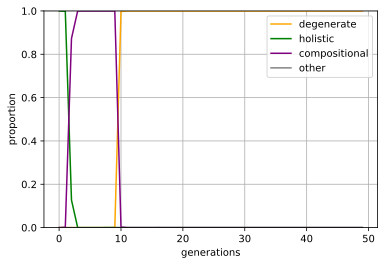

In [30]:
initial = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
communication = False
turnover = True
lang_stats,final_data= simulation(50, 20, 20, 2, initial)
plot_single_run(lang_stats)

You might notice that the results are pretty volatile; the languages switch quite rapidly and violently, which is also what we saw in the frequency-learning model in Lab 4 with small data. Given this volatility, it makes sense to average over multiple runs; to make that easier we provide the `plot_batch` function (usage example below). 

In [31]:
def plot_batch(results):

    average_degenerate = []
    average_holistic = []
    average_other = []
    average_compositional = []

    for i in range(len(results[0])):
        total_degenerate = 0
        total_holistic = 0
        total_other = 0
        total_compositional = 0
        for result in results:
            total_degenerate += result[i][0]
            total_holistic += result[i][1]
            total_other += result[i][2]
            total_compositional += result[i][3]
        average_degenerate.append(total_degenerate / len(results))
        average_holistic.append(total_holistic / len(results))
        average_other.append(total_other / len(results))
        average_compositional.append(total_compositional / len(results))

    plt.plot(average_degenerate, color='orange', label='degenerate')
    plt.plot(average_holistic, color='green', label='holistic')
    plt.plot(average_compositional, color='purple', label='compositional')
    plt.plot(average_other, color='grey', label='other')
    plt.xlabel('generations')
    plt.ylabel('proportion')
    plt.ylim([-0.01,1.01])
    plt.legend()
    plt.grid()

The following code will do 20 simulation runs and plot the average posterior mass of the four language types at each generation. Note this will take a minute or two to run - it spits out a dot every time it completes a run so you can see that it's doing something!

```python
initial = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
communication = False
turnover = True
stats = []
final_datasets = []
for i in range(20):
    print('.',end='') #printing a . after every run completes so you can see it's making progress!
    this_stats,this_final_data = simulation(50, 20, 20, 2, initial)
    stats.append(this_stats)
    final_datasets.append(this_final_data)
plot_batch(results)
```

....................

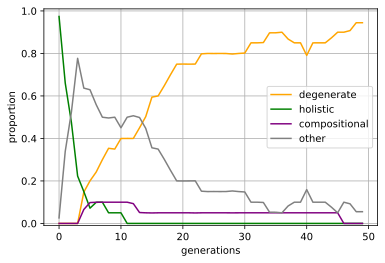

In [34]:
initial = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
communication = False
turnover = True
stats = []
final_datasets = []
for i in range(20):
    print('.',end='') #printing a . after every run completes so you can see it's making progress!
    this_stats,this_final_data = simulation(50, 20, 20, 2, initial)
    stats.append(this_stats)
    final_datasets.append(this_final_data)
plot_batch(stats)

*In the graph above you can see that under this parameter setting, the initial holistic language dies off and degenerate languages take over.*

*final_datasets is a list, each item in which is a list of the data produced by the last generation in that run of the simulation. So for example, here's how to inspect the final dataset produced by the 50th generation of the 0th run.*

In [38]:
print(final_datasets[0])

[('13', 'ab'), ('13', 'ab'), ('12', 'ab'), ('03', 'ab'), ('13', 'ab'), ('02', 'ab'), ('02', 'ab'), ('02', 'ab'), ('02', 'ab'), ('02', 'ab'), ('03', 'ab'), ('12', 'ab'), ('13', 'ab'), ('03', 'ab'), ('03', 'ab'), ('02', 'ab'), ('03', 'ab'), ('12', 'aa'), ('02', 'ab'), ('03', 'ab')]


*At least in my case, this looks like a degenerate language - for every meaning they are using the signal ab.*

## Questions

1. Try different values for the `communication` and `turnover` parameters. Can you replicate the main results from the [Kirby et al (2015)](https://www.sciencedirect.com/science/article/pii/S0010027715000815?via%3Dihub) paper?

*OK, so the result above is for ```communcation=False``` and ```turnover=True```, i.e. a vanilla iterated learning model where individuals learn the language and reporoduce it for the next generation, with no adjustments for communication (i.e. we are using the literal ```s0``` speaker who doesn;t care about being ambiguous). The results are as expected: degenerate languages dominate.*

*Next, let's see what happens if we turn transmission off (i.e. we simulate a closed population, with no transmission to new learners) and turn communication on (i.e. speakers now care about being understood). Note that I don't have to run ```wipe_stored_results()``` because I am not messing with any of the three danger parameters, possible_meanings, possible_signals, or error_probability.*

....................

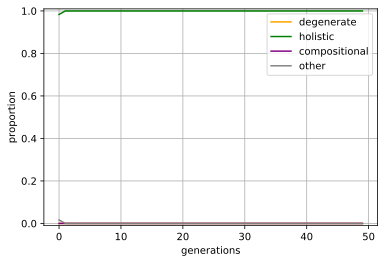

In [41]:
initial = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
communication = True
turnover = False
stats = []
final_datasets = []
for i in range(20):
    print('.',end='') #printing a . after every run completes so you can see it's making progress!
    this_stats,this_final_data = simulation(50, 20, 20, 2, initial)
    stats.append(this_stats)
    final_datasets.append(this_final_data)
plot_batch(stats)

*So in this case the results look roughly like the results from Kirby et al.. The initial holistic languages are preserved, and in fact very little changes over 'generations', i.e. rounds of interaction - each pair starts with a holistic language which works well for communication, so there is no drive from communication pressures to change it, and the fact that the initial language is disprerred in the prior doesn't matter, because there is no transmission to new learners.*

*Finally we can see what happens in the interesting condition, with communication and transmission both turned on. This is where we expect compositional languages to develop - they work for communication, unlike the degenerate languages, but they have higher prior probability than the holistic languages, so are favoured during learning.*

....................

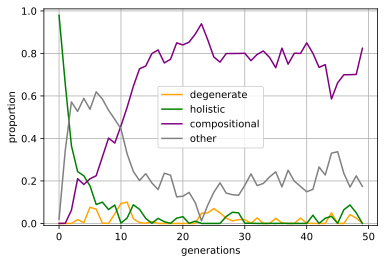

In [42]:
initial = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
communication = True
turnover = True
stats = []
final_datasets = []
for i in range(20):
    print('.',end='') #printing a . after every run completes so you can see it's making progress!
    this_stats,this_final_data = simulation(50, 20, 20, 2, initial)
    stats.append(this_stats)
    final_datasets.append(this_final_data)
plot_batch(stats)

*Again, the results look as expected here - the initial holistic language dies off, and after a bump in the 'other' category the compositional languages take over. So the main results from the 2015 paper seem to replicate - you get compositional languages when transmission and communication are both at play.*

2. With both communicatively pragmatic speakers and population turnover, what effect does changing the bottleneck size have, and why?

*Before you run any code, think about what you would predict for this. Remember, in Bayesian models the outcome of learning is shaped by the prior and the data, the more data you have the less influence the prior has on each learner, the less data you have the greater the influence of the prior.* 

*OK, so for the result above the bottleneck was set to 20 (```bottleneck``` is the third parameter of the ```simulation``` function). Let's try a bunch of runs with a progressively tighter bottleneck - 15, 10, 5.* 

....................

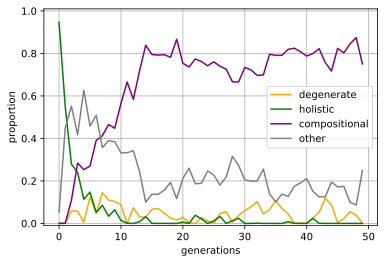

In [43]:
initial = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
communication = True
turnover = True
stats = []
final_datasets = []
for i in range(20):
    print('.',end='') #printing a . after every run completes so you can see it's making progress!
    this_stats,this_final_data = simulation(50, 20, 15, 2, initial)
    stats.append(this_stats)
    final_datasets.append(this_final_data)
plot_batch(stats)

....................

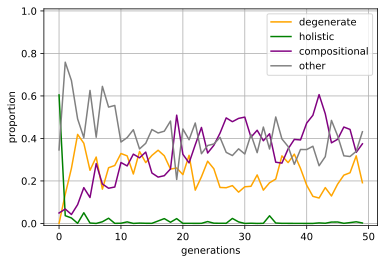

In [44]:
initial = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
communication = True
turnover = True
stats = []
final_datasets = []
for i in range(20):
    print('.',end='') #printing a . after every run completes so you can see it's making progress!
    this_stats,this_final_data = simulation(50, 20, 10, 2, initial)
    stats.append(this_stats)
    final_datasets.append(this_final_data)
plot_batch(stats)

....................

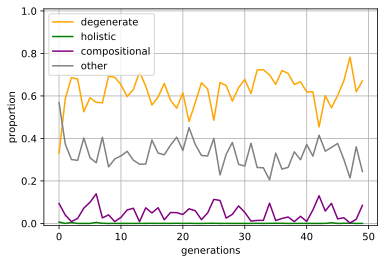

In [45]:
initial = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
communication = True
turnover = True
stats = []
final_datasets = []
for i in range(20):
    print('.',end='') #printing a . after every run completes so you can see it's making progress!
    this_stats,this_final_data = simulation(50, 20, 5, 2, initial)
    stats.append(this_stats)
    final_datasets.append(this_final_data)
plot_batch(stats)

*OK, so as the bottleneck tightens we see compositional languages lose their dominance - for bottleneck size 10 it looks like the 'other' languages (which are part-degenerate and therefore have higher prior probability) start doing well, and then when the bottleneck is very tight the degenerate languages (which have the highest prior probability) take over.*

*Now let's look at what happens when we increase the bottleneck size, and provide learners with more data to learn from. We'll look at bottleneck sizes of 30, 40 and 50.*

....................

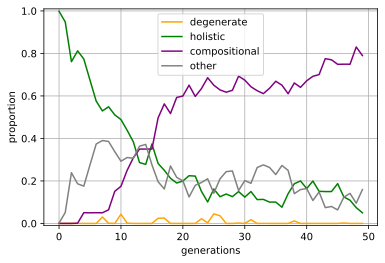

In [46]:
initial = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
communication = True
turnover = True
stats = []
final_datasets = []
for i in range(20):
    print('.',end='') #printing a . after every run completes so you can see it's making progress!
    this_stats,this_final_data = simulation(50, 20, 30, 2, initial)
    stats.append(this_stats)
    final_datasets.append(this_final_data)
plot_batch(stats)

....................

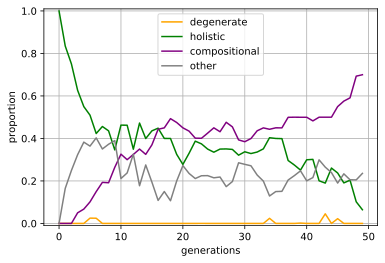

In [47]:
initial = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
communication = True
turnover = True
stats = []
final_datasets = []
for i in range(20):
    print('.',end='') #printing a . after every run completes so you can see it's making progress!
    this_stats,this_final_data = simulation(50, 20, 40, 2, initial)
    stats.append(this_stats)
    final_datasets.append(this_final_data)
plot_batch(stats)

....................

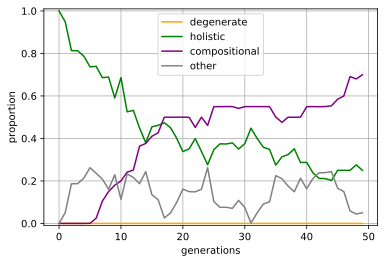

In [48]:
initial = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
communication = True
turnover = True
stats = []
final_datasets = []
for i in range(20):
    print('.',end='') #printing a . after every run completes so you can see it's making progress!
    this_stats,this_final_data = simulation(50, 20, 50, 2, initial)
    stats.append(this_stats)
    final_datasets.append(this_final_data)
plot_batch(stats)

*With the wider bottleneck the compositional languages still win out, but it takes longer, and the holistic languages seem to have a larger share after 50 generations. So those results largely match what's expected - more influence of the prior when the bottleneck is tight (I think that result is quite clear), less influence of the prior and slower change in general when the bottleneck is wide (or at least everything happens more slowly).*

3. What happens if you initialise the chains with a different type of language, rather than a holistic one? Do all the main results still hold up?

*We actually did this in an appendix in the paper (on the basis of a suggestion from a reviewer), it does actually make a bit of a difference.*

*I think there are two obvious interesting starting languages to look at: rather than starting with a holistic language, we can start with degenerate languages, or compositional languages.*

*Let's do degenerate first. I'll do all 3 versions of the model, with the different settings of ```communication``` and ```turnover```.*

....................

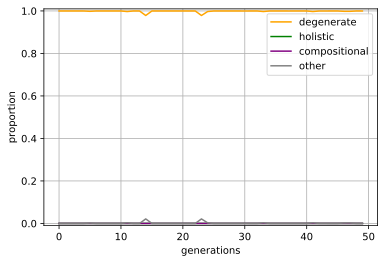

In [49]:
initial = [('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'aa')]
communication = False
turnover = True
stats = []
final_datasets = []
for i in range(20):
    print('.',end='') #printing a . after every run completes so you can see it's making progress!
    this_stats,this_final_data = simulation(50, 20, 20, 2, initial)
    stats.append(this_stats)
    final_datasets.append(this_final_data)
plot_batch(stats)

....................

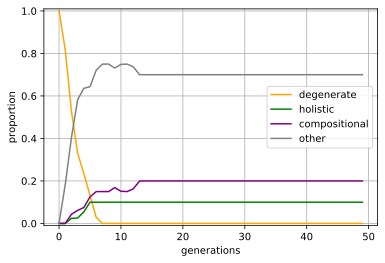

In [50]:
initial = [('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'aa')]
communication = True
turnover = False
stats = []
final_datasets = []
for i in range(20):
    print('.',end='') #printing a . after every run completes so you can see it's making progress!
    this_stats,this_final_data = simulation(50, 20, 20, 2, initial)
    stats.append(this_stats)
    final_datasets.append(this_final_data)
plot_batch(stats)

....................

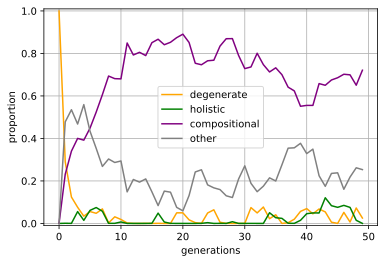

In [51]:
initial = [('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'aa')]
communication = True
turnover = True
stats = []
final_datasets = []
for i in range(20):
    print('.',end='') #printing a . after every run completes so you can see it's making progress!
    this_stats,this_final_data = simulation(50, 20, 20, 2, initial)
    stats.append(this_stats)
    final_datasets.append(this_final_data)
plot_batch(stats)

*OK, so the results for the ```transmission=True``` conditions look basically the same if we start from a degenerate language - degenerate languages start frequent and stay frequent in the ```transmission=True```, ```communication=False``` condition, and compositional languages still win when we have ```transmission=True```, ```communication=True```. But the results for ```transmission=False```, ```communication=True``` look a bit different - we still don't see compositional languages or degenerate languages, most pairs seem to ditch the initial degenerate language (bcause they are no good for communication) but get 'stuck' with a language in the 'other' category, and never find their way to holistic languages.*

*Now the same thing but starting from a compositional language...*

....................

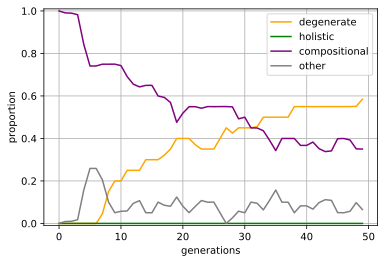

In [52]:
initial = [('02', 'aa'), ('03', 'ab'), ('12', 'ba'), ('13', 'bb')]
communication = False
turnover = True
stats = []
final_datasets = []
for i in range(20):
    print('.',end='') #printing a . after every run completes so you can see it's making progress!
    this_stats,this_final_data = simulation(50, 20, 20, 2, initial)
    stats.append(this_stats)
    final_datasets.append(this_final_data)
plot_batch(stats)

....................

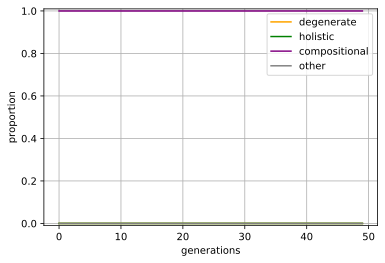

In [53]:
initial = [('02', 'aa'), ('03', 'ab'), ('12', 'ba'), ('13', 'bb')]
communication = True
turnover = False
stats = []
final_datasets = []
for i in range(20):
    print('.',end='') #printing a . after every run completes so you can see it's making progress!
    this_stats,this_final_data = simulation(50, 20, 20, 2, initial)
    stats.append(this_stats)
    final_datasets.append(this_final_data)
plot_batch(stats)

....................

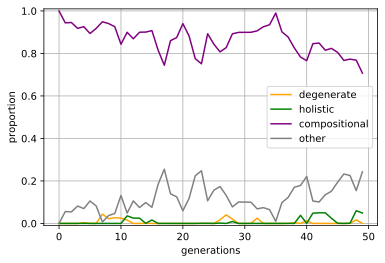

In [54]:
initial = [('02', 'aa'), ('03', 'ab'), ('12', 'ba'), ('13', 'bb')]
communication = True
turnover = True
stats = []
final_datasets = []
for i in range(20):
    print('.',end='') #printing a . after every run completes so you can see it's making progress!
    this_stats,this_final_data = simulation(50, 20, 20, 2, initial)
    stats.append(this_stats)
    final_datasets.append(this_final_data)
plot_batch(stats)

*Once again, results in the conditions with transmission look basically the same - you get degenerate languages slowly taking over if communication is not turned on, and compositional languages remaining dominant if both communication and transmission are at play. But once again the results are different in the ```transmission=False```, ```communication=True``` condition. Here the prior plays very little role, and all that matters is communication. Compositional languages are perfectly good for unambiguous communication, so they are simply preserved, just like holistic languages.*

4. This code also allows us to manipulate the size of the population: unlike in the iterated learning experiment in Lab 4, where each generation consists of a single individual, here we can have multiple individuals per generation. Experiment with different population sizes (possibly in conjunction with different values for the `communication` and `turnover` parameters) and see if it has any effect.

*I'll leave you to play around with this yourself - the fourth parameter of the ```simulate``` function is the population size, we have been using a population size of 2 but you can plug in other values and see what happens. My expectation is that the results will be roughly the same, but find out!*

5. In our `update_prior` function we model learners who assume that they are learning from literal speakers, i.e. they don't reason about the likely behaviour of a pragmatic speaker when inferring the grammar which accounts for the data they encounter. How would you change the `update_prior` function to model learners who can reason about a pragmatic speaker? How could you change it so learners sometimes made this inference? If you can implement this change, how does it affect the results of the simulations, and why?

*This would be changed in the ```update_posterior``` function - the likelihood function in there is*
```python
signal_probabilities = s0(meaning,possible_languages[i])
```
*i.e. the literal speaker, but you can trivially change this to ```s1```, the pragmatic speaker, so that the learner reasons about a pragmatic speaker when trying to infer what grammar lies behind their data. Change that and then try re-running the 3 standard models. You will find it has a huge effect on the results! If learners can infer that even speakers with degenerate grammars might not produce degenerate data (because they are trying to be informative), then suddenly **all** the learner's data becomes quite uniformative about the speaker's actual grammar, and the prior has a much larger influence. The larger the influence of the prior, the more we see degenerate languages. So in order to get this model to produce 'interesting' results, i.e. compositional languages, learners can't fully reverse-engineer a pragmatic speaker when learning.*

*You could also try changing the model so learners sometimes use the literal speaker model, and sometimes use the pragmatic speaker model (e.g. probabilistically) - I would be interested to see whether that produces intermediate results.*

## References

Kirby, S., Tamariz, M., Cornish, H., & Smith, K. (2015). Compression and Communication in the Cultural Evolution of Linguistic Structure. *Cognition, 141,* 87-102. 